In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Helper functions to create Tensorflow Deep Neural Network Graph

def weights(shape):
        '''
        Creates the filters and bias' for the convolutions/pooling layers of the inception_module

        Parameters:
            shape: The shape of the weight tensor.
                    For dense_layers, this should be [num_inputs_to_layer, num_outputs_of_layer].
                    Note: Number of outputs for a layer is equivalent to the number of neurons in that layer.
        Returns:
            The tensor weight variable
        '''
        return(tf.Variable(tf.truncated_normal(shape, stddev=0.1, name="weights")))

def bias(shape, initial_value=0.1):
    '''
    Create a bias variable. Note it is initalized by default to 0.1
        
    Parameters:
        shape: The shape of the bias tensor. This should be a 1D shape equal to the number of outputs of
                a layer.
        initial_value: The initial value of all the bias's
            
    Returns:
           The tensor bias variable 
    '''
    return(tf.Variable(tf.constant(initial_value, shape=shape, name="bias")))

def conv2d(inputs, weights, bias, strides, padding="SAME"):
    '''
    Perfroms a 2D convolution on the input tensor.
    
    Parameters:
        inputs: The input tensors to run 2d convolution. Must have shape  [batch_size, width, height, input_channels]
        weights: The weights used to perform convolution. Must have shape [input_channels, filter_width, filter_height, output_channels]
        bias: The bias used after computing convolution. Must have shape [output_channels]
    '''
    x = tf.nn.conv2d(inputs, weights, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, bias)
    return tf.nn.leaky_relu(x)

def dense_layer(inputs, weights, bias, activation=None):
    '''
    Build a fully connected dense neuron layer. 
    
    Parameters:
        inputs: An input tensor with shape [batch_size, num_inputs]
        weights: A tensor with shape [num_inputs, num_outputs]
        bias: A tensor with shape [num_outputs]
        activation: A valid tensorflow activation function.(EX. tf.nn.relu())
    '''
    output = tf.matmul(inputs, weights) + bias
    if activation is None:
        return(output)
    return(activation(output))

In [3]:
def projection(weights, p_norm, lamda):
    '''
    Projection function on a weights matrix to constrain the lipschitz constant.
    
    Parameters:
        weights: The weights tenosr of a neuron layer
        p_norm: The The distance norm to be computed for the weights
        lamda: Hyperparameter to control the upper bound of the Lipschitz constant
    
    Returns: 
        Assignment operation to update the weights tensor.
        weights_norm: The p_norm of the weights tensro
    '''
    one_scalar = tf.constant(1, dtype=tf.float32)
    lamda = tf.constant(lamda, dtype=tf.float32)
    
    #compute the p_norm of the weight matrix
    weights_norm = tf.norm(weights, ord=p_norm)
    weight_bound = tf.divide(weights_norm, lamda)
    projection_parameter = tf.divide(one_scalar, tf.maximum(one_scalar, weight_bound))
    weights_projection = tf.multiply(projection_parameter, weights)
    
    return(tf.assign(weights, weights_projection), weights_norm)

In [4]:
#Network model
num_inputs = 28*28
num_hidden1 = 300
num_hidden2 = 100
num_hidden3 = 10

with tf.name_scope("dnn_model"):
    
    #insertion point for input data to model
    X = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs])
    labels = tf.placeholder(dtype=tf.int32, shape=None)
    
    #hidden layer 1
    w1 = weights([num_inputs, num_hidden1])
    b1 = bias([num_hidden1])
    z1 = dense_layer(X, w1, b1, activation=tf.nn.relu)

    #hidden layer 2
    w2 = weights([num_hidden1, num_hidden2])
    b2 = bias([num_hidden2])
    z2 = dense_layer(z1, w2, b2, activation=tf.nn.relu)

    #hidden layer 3
    w3 = weights([num_hidden2, num_hidden3])
    b3 = bias([num_hidden3])
    logits = dense_layer(z2, w3, b3, activation=None)
    
#next we define the cost function of the neural net using softmax for activation and cross entropy for cost
with tf.name_scope("loss"):
	#this function computes both the softmax activation and cross entropy cost.
	xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)

	#give the means cross entropy across all instances
	loss = tf.reduce_mean(xentropy, name="loss")

In [5]:
#define the gradient descent optimizer to minimize the cost function
learning_rate = 0.01
with tf.name_scope("train"):
	optimizer = tf.train.GradientDescentOptimizer(learning_rate)
	training_op = optimizer.minimize(loss)


In [6]:
#define how we will evaluate the validity of the neural network
with tf.name_scope("eval"):
	correct = tf.nn.in_top_k(logits, labels, 1)
	accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [27]:
with tf.name_scope("lipshitz_regularization"):
    p_norm=1
    lamda1 = 5000
    lamda2 = 10000
    lamda3 = 100
    #layer one regularization
    w1_projection, w1_norm = projection(w1, p_norm=p_norm, lamda=lamda1)
    w2_projection, w2_norm = projection(w2, p_norm=p_norm, lamda=lamda2)
    w3_projection, w3_norm = projection(w3, p_norm=p_norm, lamda=lamda3)


In [31]:
#node to initialize all of the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")
n_epochs = 20
batch_size = 100

w1_norm_data = []
w2_norm_data = []
w3_norm_data = []
acc_train =[]
acc_val = []
loss_val =[]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)

            sess.run(training_op, feed_dict={X: X_batch, labels: y_batch})
            
            #sess.run(w1_projection)
            #sess.run(w2_projection)
            #sess.run(w3_projection)
            
        #Save the norms of the weight matrices
        w1_norm_data.append(sess.run(w1_norm))
        w2_norm_data.append(sess.run(w2_norm))
        w3_norm_data.append(sess.run(w3_norm))
        
        acc_train.append(accuracy.eval(feed_dict={X: X_batch, labels:y_batch}))
        acc_val.append(accuracy.eval(feed_dict={X: mnist.validation.images, labels: mnist.validation.labels}))
        loss_val.append(loss.eval(feed_dict={X:mnist.validation.images, labels:mnist.validation.labels}))
        print(epoch, "Train accuracy:", acc_train[-1], "Val accuracy:", acc_val[-1], "Val Loss", loss_val[-1])

Extracting /tmp/data\train-images-idx3-ubyte.gz
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.9 Val accuracy: 0.874 Val Loss 0.507529
1 Train accuracy: 0.89 Val accuracy: 0.9026 Val Loss 0.36652103
2 Train accuracy: 0.92 Val accuracy: 0.9176 Val Loss 0.31453228
3 Train accuracy: 0.89 Val accuracy: 0.9236 Val Loss 0.28646278
4 Train accuracy: 0.9 Val accuracy: 0.9294 Val Loss 0.2669083
5 Train accuracy: 0.93 Val accuracy: 0.9322 Val Loss 0.25078735
6 Train accuracy: 0.88 Val accuracy: 0.9354 Val Loss 0.23859507
7 Train accuracy: 0.92 Val accuracy: 0.9356 Val Loss 0.22763525
8 Train accuracy: 0.91 Val accuracy: 0.94 Val Loss 0.21615651
9 Train accuracy: 0.94 Val accuracy: 0.9432 Val Loss 0.20961045
10 Train accuracy: 0.98 Val accuracy: 0.9428 Val Loss 0.199574
11 Train accuracy: 0.95 Val accuracy: 0.9452 Val Loss 0.19321164
12 Train accuracy: 0.96 Val accuracy: 0.9454 Val L

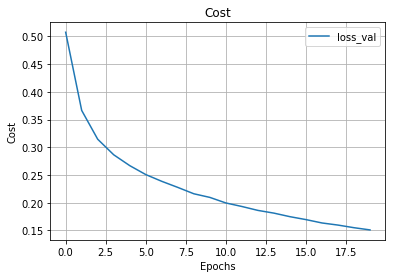

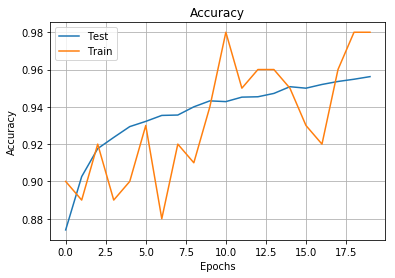

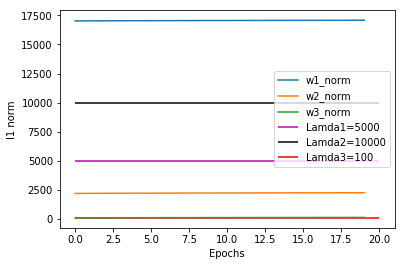

In [32]:
#Plot cost data
plt.figure(1)
plt.grid(True)
plt.title("Cost")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.plot(loss_val, label="loss_val")
plt.plot
plt.legend()

#Plot accuracy data
plt.figure(2)
plt.grid(True)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(acc_val, label="Test")
plt.plot(acc_train, label="Train")
plt.legend()

#plot weight norms data
plt.figure(3)
plt.xlabel("Epochs")
plt.ylabel("l"+str(p_norm)+" norm")
plt.plot(w1_norm_data, label="w1_norm")
plt.hlines(lamda1, xmin=0, xmax=n_epochs, colors="m", label="Lamda1="+str(lamda1))
plt.plot(w2_norm_data, label="w2_norm")
plt.hlines(lamda2, xmin=0, xmax=n_epochs, colors="k", label="Lamda2="+str(lamda2))
plt.plot(w3_norm_data, label="w3_norm")
plt.hlines(lamda3, xmin=0, xmax=n_epochs, colors="r", label="Lamda3="+str(lamda3))
plt.legend()

plt.show()